In [1]:
import os 
import sys
import time

paths_to_add = [
    os.path.abspath(os.path.join('../..')),  
    os.path.abspath(os.path.join('..'))  
]

sys.path.extend(path for path in paths_to_add if path not in sys.path)

In [2]:
import jax
from jax import jit, vmap
import jax.numpy as jnp
import numpy as np
import scipy.stats
from jax import random
import matplotlib.pyplot as plt

from fbpinns import networks
from fbpinns.domains import RectangularDomainND
from fbpinns.decompositions import RectangularDecompositionND
from fbpinns.networks import FCN
from fbpinns.schedulers import LineSchedulerRectangularND, AllActiveSchedulerND
from fbpinns.constants import Constants, get_subdomain_ws
from fbpinns.trainers import FBPINNTrainer

from cooksDomain import CooksDomainND
from CooksMembrane.cooksProblem import CooksProblemForwardSoft, CooksProblemForwardSoftVersion2

c:\Users\tirth\anaconda3\envs\fbpinns\Lib\site-packages\scipy\stats\_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


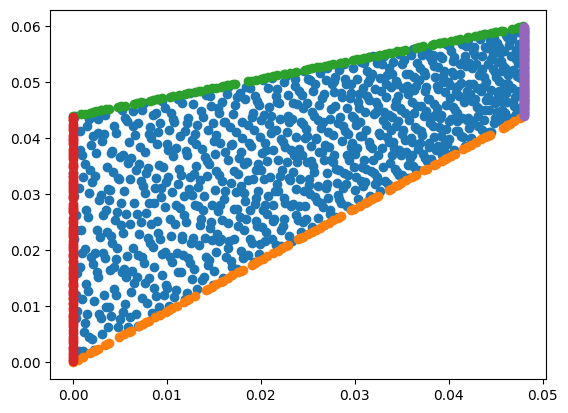

In [3]:
# step 1: Domain
corners = jnp.array([(0., 0.), (0, 0.044), (0.048, 0.060), (0.048, 0.044)]) 
domain = CooksDomainND
domain_init_kwargs = dict(
    corners=corners,
)
domain_init_kwargs

# Example 2D Plot
key = jax.random.PRNGKey(0)
all_params = {
    "static": {
        "domain": {
            "xd": 2,
            "corners": corners,
        }
    }
}

batch_shape = (30,30)  # for example
x_batch = domain.sample_interior(all_params, key, 'sobol', batch_shape)

batch_shapes = ((100,),(100,),(100,),(100,)) # bottom, top, left, right
x_boundaries = domain.sample_boundaries(all_params, key, 'sobol', batch_shapes)

plt.scatter(x_batch[:, 0:1], x_batch[:, 1:2])
for x_batch_b in x_boundaries:
        plt.scatter(x_batch_b[:,0], x_batch_b[:,1], )

In [5]:
# step 2: prbolem
problem = CooksProblemForwardSoftVersion2
problem_init_kwargs = dict(lambda_true= 4, mu_true = 5, 
                    nbc_points_right = 300, nbc_points_top=300, 
                    nbc_points_bottom=300, dbc_points_left=300, sd=0.1)
problem_init_kwargs

{'lambda_true': 4,
 'mu_true': 5,
 'nbc_points_right': 300,
 'nbc_points_top': 300,
 'nbc_points_bottom': 300,
 'dbc_points_left': 300,
 'sd': 0.1}

{'subdomain_xs': [array([0.        , 0.00685714, 0.01371429, 0.02057143, 0.02742857,
       0.03428571, 0.04114286, 0.048     ]), array([0.        , 0.00857143, 0.01714286, 0.02571429, 0.03428571,
       0.04285714, 0.05142857, 0.06      ])], 'subdomain_ws': [array([0.01302857, 0.01302857, 0.01302857, 0.01302857, 0.01302857,
       0.01302857, 0.01302857, 0.01302857]), array([0.01628571, 0.01628571, 0.01628571, 0.01628571, 0.01628571,
       0.01628571, 0.01628571, 0.01628571])], 'unnorm': (0.0, 3.0)}


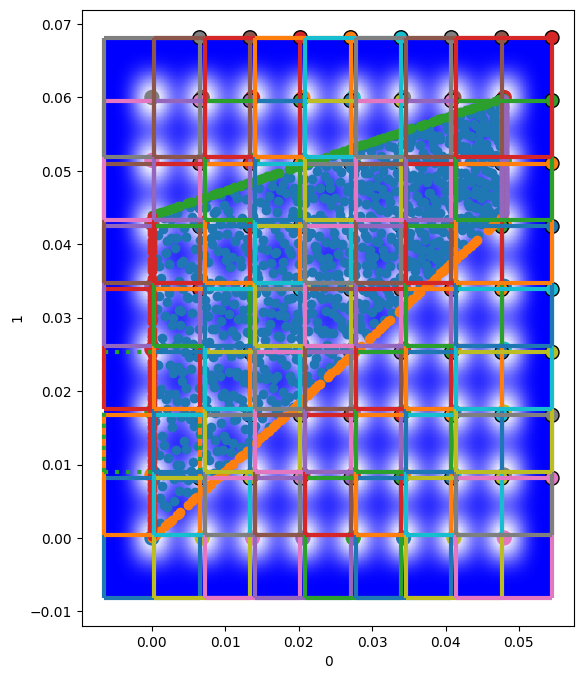

In [6]:
# step 3: decompostion
decomposition = RectangularDecompositionND
wo = 1.9
subdomain_xs = [np.linspace(0,0.048,8), np.linspace(0,0.060,8)]
# subdomain_xs = [[0.014, 0.034], [0.018, 0.042]]
subdomain_ws=get_subdomain_ws(subdomain_xs, wo)
decomposition_init_kwargs = dict(
    subdomain_xs=subdomain_xs,
    subdomain_ws=get_subdomain_ws(subdomain_xs, wo),
    unnorm=(0.,3.),
)
print(decomposition_init_kwargs)

# plot 2D
ps_ = decomposition.init_params(subdomain_xs, subdomain_ws, (0,3))
all_params = {"static":{"decomposition":ps_[0]}, "trainable":{"decomposition":ps_[1]}}
m = all_params["static"]["decomposition"]["m"]
active = np.ones(m)

# active[1] = 0
active[2] = 2
decomposition.plot(all_params, active=active, show_norm=True, show_window=True)

# for x in x_batch:
#     plt.scatter(x[0], x[1])
plt.scatter(x_batch[:, 0:1], x_batch[:, 1:2])
for x_batch_b in x_boundaries:
        plt.scatter(x_batch_b[:,0], x_batch_b[:,1], )
plt.show()

In [7]:
# step 4: network
network=FCN
network_init_kwargs = dict(
    layer_sizes = (2, 128, 5),
)

In [8]:
# step 5 scheduler # try with all active together
scheduler = AllActiveSchedulerND
scheduler_kwargs = dict()
# scheduler = LineSchedulerRectangularND
# scheduler_kwargs = dict(
#     point=[0.024], iaxis=0,
# )

In [9]:
tag = "adaptive"
nc = (20,20)
epochs = 20000
h = len(network_init_kwargs["layer_sizes"]) - 2
p = sum(network_init_kwargs["layer_sizes"][1:-1])
run = f"FBPINN_{tag}_{problem.__name__}_{network.__name__}_{nc}-nCol_{epochs}-epochs_{h}-layers_{p}-hidden_{wo}_wo_{AllActiveSchedulerND.__name__}_fixedWeights_{subdomain_xs[0].shape, subdomain_xs[1].shape}"
run

'FBPINN_adaptive_CooksProblemForwardSoftVersion2_FCN_(20, 20)-nCol_20000-epochs_1-layers_128-hidden_1.9_wo_AllActiveSchedulerND_fixedWeights_((8,), (8,))'

In [10]:

from fbpinns.constants import Constants

c = Constants(
    run=run,
    domain=domain,
    domain_init_kwargs=domain_init_kwargs,
    problem=problem,
    problem_init_kwargs=problem_init_kwargs,
    decomposition=decomposition,
    decomposition_init_kwargs=decomposition_init_kwargs,
    network=network,
    network_init_kwargs=network_init_kwargs,
    scheduler=scheduler,
    scheduler_kwargs=scheduler_kwargs,
    ns=(nc,),# use 200 collocation points for training
    n_test=(5,5),# use 500 points for testing
    n_steps=epochs,# number of training steps
    clear_output=True,
    show_figures=False,
    test_freq=150000,
    model_save_freq=5000,
    skip_plot_at_first=True,
    sampler='sobol',
)
print(c)

run: FBPINN_adaptive_CooksProblemForwardSoftVersion2_FCN_(20, 20)-nCol_20000-epochs_1-layers_128-hidden_1.9_wo_AllActiveSchedulerND_fixedWeights_((8,), (8,))
domain: <class 'cooksDomain.CooksDomainND'>
domain_init_kwargs: {'corners': Array([[0.   , 0.   ],
       [0.   , 0.044],
       [0.048, 0.06 ],
       [0.048, 0.044]], dtype=float32)}
problem: <class 'CooksMembrane.cooksProblem.CooksProblemForwardSoftVersion2'>
problem_init_kwargs: {'lambda_true': 4, 'mu_true': 5, 'nbc_points_right': 300, 'nbc_points_top': 300, 'nbc_points_bottom': 300, 'dbc_points_left': 300, 'sd': 0.1}
decomposition: <class 'fbpinns.decompositions.RectangularDecompositionND'>
decomposition_init_kwargs: {'subdomain_xs': [array([0.        , 0.00685714, 0.01371429, 0.02057143, 0.02742857,
       0.03428571, 0.04114286, 0.048     ]), array([0.        , 0.00857143, 0.01714286, 0.02571429, 0.03428571,
       0.04285714, 0.05142857, 0.06      ])], 'subdomain_ws': [array([0.01302857, 0.01302857, 0.01302857, 0.01302857,

In [32]:
training_time = time.time()
FBPINNrun = FBPINNTrainer(c)
FBPINNrun.train()

training_time = time.time() - training_time
print(training_time)

[INFO] 2024-03-26 23:53:29 - <fbpinns.constants.Constants object at 0x00000215A17FD430>
run: FBPINN_adaptive_CooksProblemForwardSoftVersion2_FCN_(20, 20)-nCol_20000-epochs_1-layers_128-hidden_1.9_wo_AllActiveSchedulerND_fixedWeights_((8,), (8,))
domain: <class 'cooksDomain.CooksDomainND'>
domain_init_kwargs: {'corners': Array([[0.   , 0.   ],
       [0.   , 0.044],
       [0.048, 0.06 ],
       [0.048, 0.044]], dtype=float32)}
problem: <class 'CooksMembrane.cooksProblem.CooksProblemForwardSoftVersion2'>
problem_init_kwargs: {'lambda_true': 4, 'mu_true': 5, 'nbc_points_right': 300, 'nbc_points_top': 300, 'nbc_points_bottom': 200, 'dbc_points_left': 300, 'sd': 0.1}
decomposition: <class 'fbpinns.decompositions.RectangularDecompositionND'>
decomposition_init_kwargs: {'subdomain_xs': [array([0.        , 0.00685714, 0.01371429, 0.02057143, 0.02742857,
       0.03428571, 0.04114286, 0.048     ]), array([0.        , 0.00857143, 0.01714286, 0.02571429, 0.03428571,
       0.04285714, 0.05142857

c:\Users\tirth\anaconda3\envs\fbpinns\Lib\site-packages\scipy\stats\_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


[INFO] 2024-03-26 23:53:30 - [i: 0/20000] Updating active inputs..
[INFO] 2024-03-26 23:53:30 - [i: 0/20000] Average number of points/dimension in active subdomains: 8.30
[INFO] 2024-03-26 23:53:32 - [i: 0/20000] Updating active inputs done (1.74 s)
[INFO] 2024-03-26 23:53:32 - [i: 0/20000] Compiling update step..
[INFO] 2024-03-26 23:53:32 - x_batch
[INFO] 2024-03-26 23:53:32 - (400, 2), float32, JVPTracer
[INFO] 2024-03-26 23:53:32 - x_take
[INFO] 2024-03-26 23:53:32 - (1456, 2), float32, JVPTracer
[INFO] 2024-03-26 23:53:32 - x_batch
[INFO] 2024-03-26 23:53:32 - (400, 2), float32, JVPTracer
[INFO] 2024-03-26 23:53:32 - x_take
[INFO] 2024-03-26 23:53:32 - (1456, 2), float32, JVPTracer
[INFO] 2024-03-26 23:53:32 - x_batch
[INFO] 2024-03-26 23:53:32 - (300, 2), float32, DynamicJaxprTracer
[INFO] 2024-03-26 23:53:32 - x_take
[INFO] 2024-03-26 23:53:32 - (575, 2), float32, DynamicJaxprTracer
[INFO] 2024-03-26 23:53:32 - x_batch
[INFO] 2024-03-26 23:53:32 - (300, 2), float32, DynamicJaxpr

In [13]:
from FBPINNsModel.plot import load_FBPINN, load_PINN, exact_solution
from fbpinns.analysis import load_model

# run = "test"
# load model
c, model = load_model(run, rootdir="results/")

# Test model
from fbpinns.analysis import FBPINN_solution, PINN_solution
i, all_params, all_opt_states, active, u_test_losses = model
x_batch_test = domain.sample_interior(all_params=all_params, key=None, sampler="grid", batch_shape=(500,500))
out = FBPINN_solution(c, all_params, active, x_batch_test)

ux_test, uy_test, sigmaxx_test, sigmayy_test, sigmaxy_test  = out[:,0:1],out[:,1:2],out[:,2:3],out[:,3:4],out[:,4:5]

[INFO] 2024-03-27 11:22:37 - Loading model from:
results/models/FBPINN_adaptive_CooksProblemForwardSoftVersion2_FCN_(20, 20)-nCol_20000-epochs_1-layers_128-hidden_1.9_wo_AllActiveSchedulerND_fixedWeights_((8,), (8,))/model_00020000.jax
[INFO] 2024-03-27 11:22:38 - x_batch
[INFO] 2024-03-27 11:22:38 - (250000, 2), float32, ArrayImpl
[INFO] 2024-03-27 11:22:38 - x_take
[INFO] 2024-03-27 11:22:38 - (903326, 2), float32, ArrayImpl


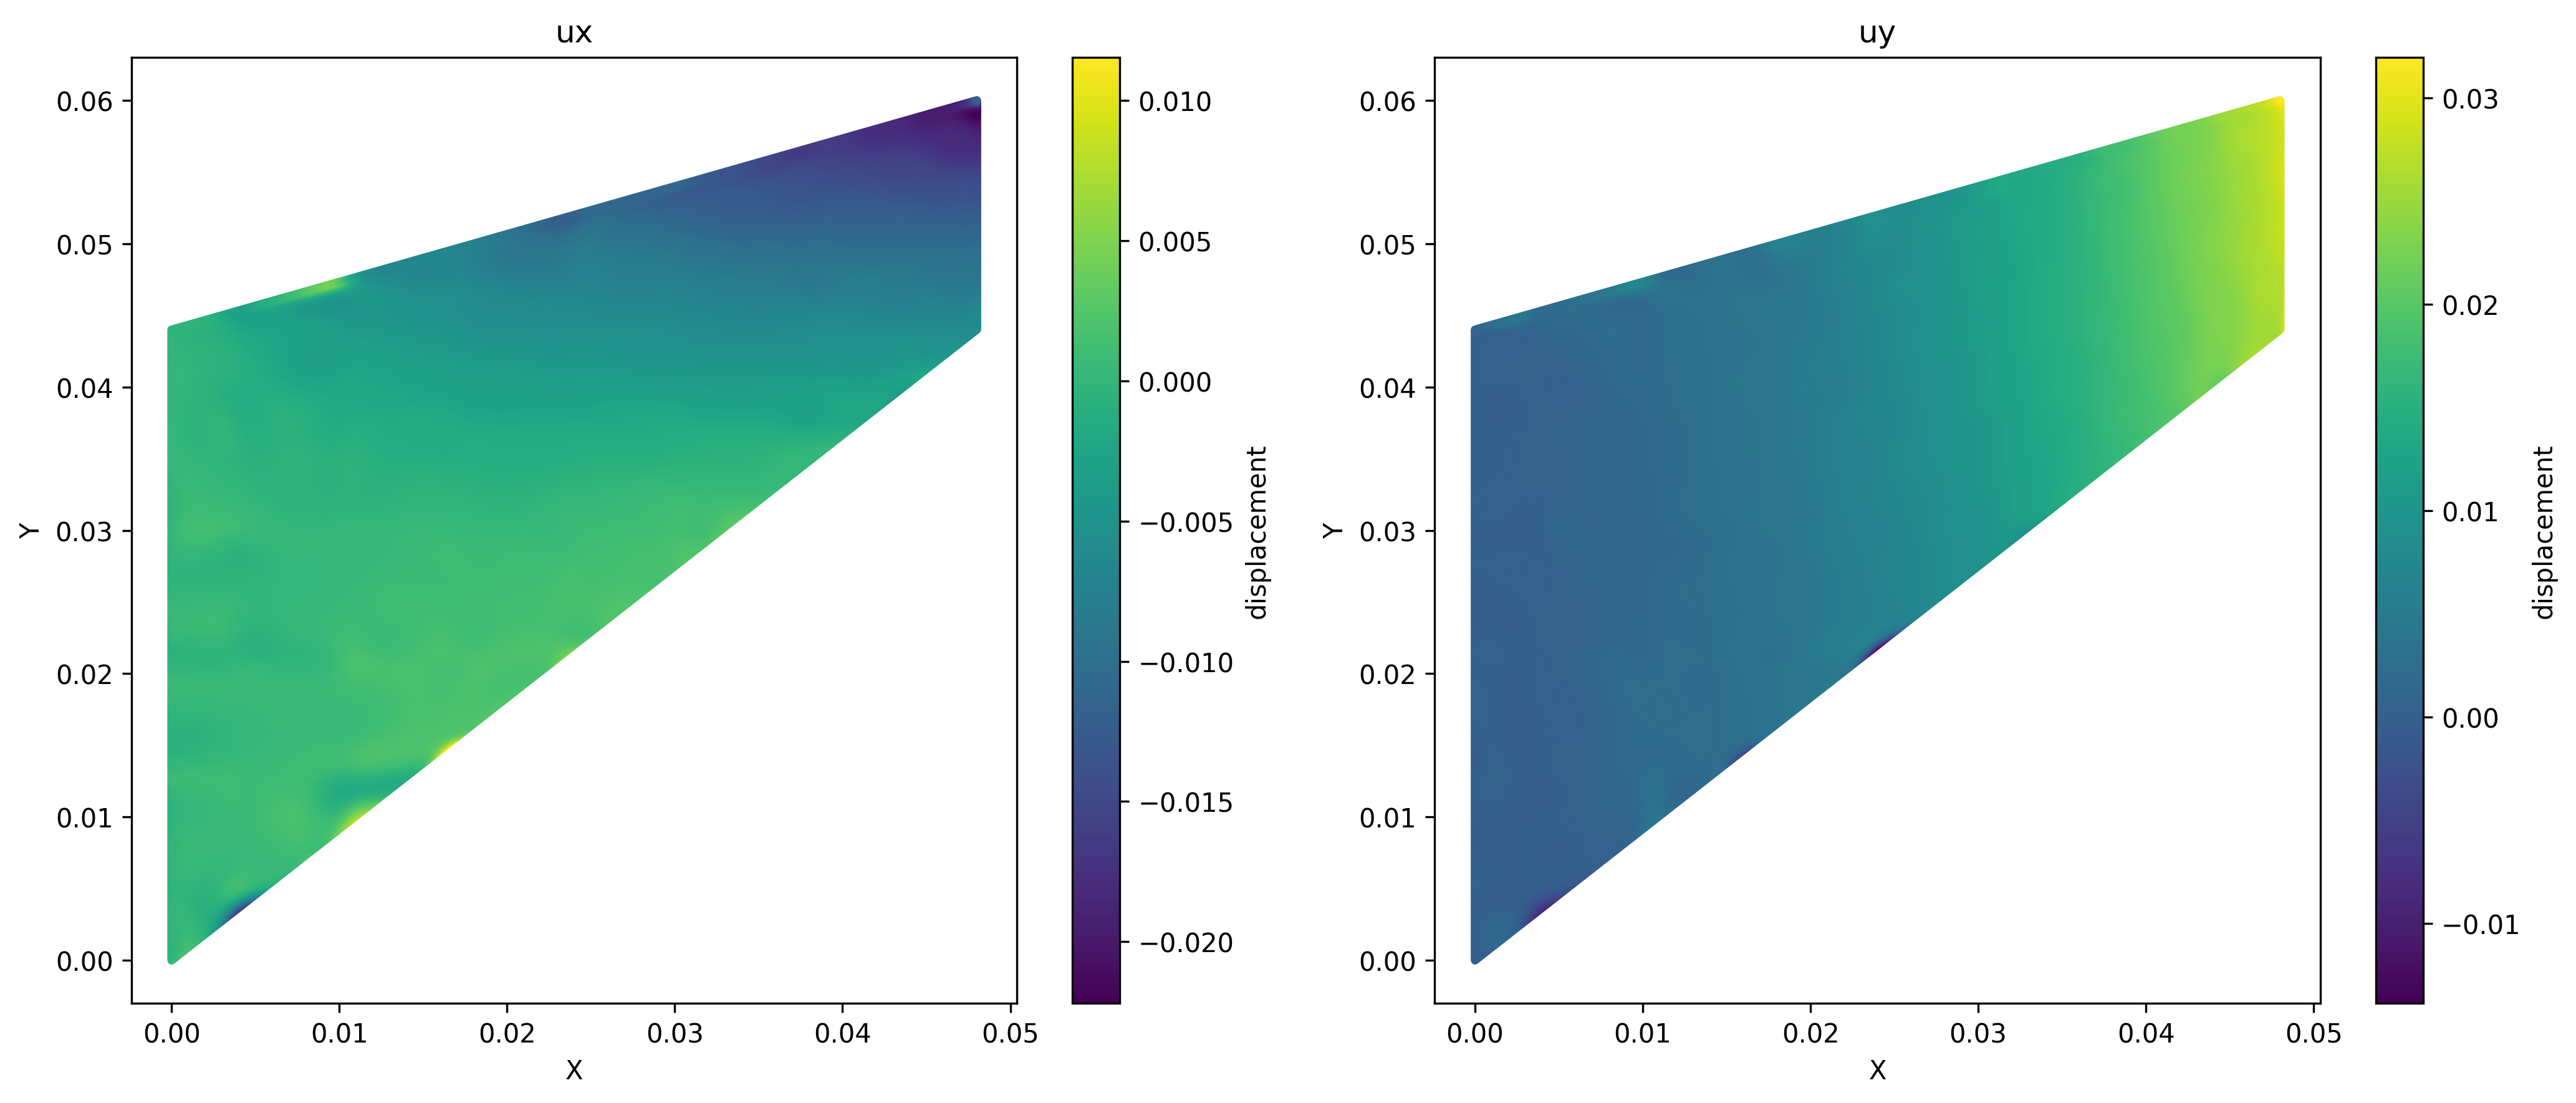

In [12]:
from CooksMembrane.util import plot_deformation

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), dpi=300)
plot_deformation(ux_test, x_batch_test,ax1,"ux")
plot_deformation(uy_test, x_batch_test,ax2,"uy")
plt.tight_layout()
plt.show()

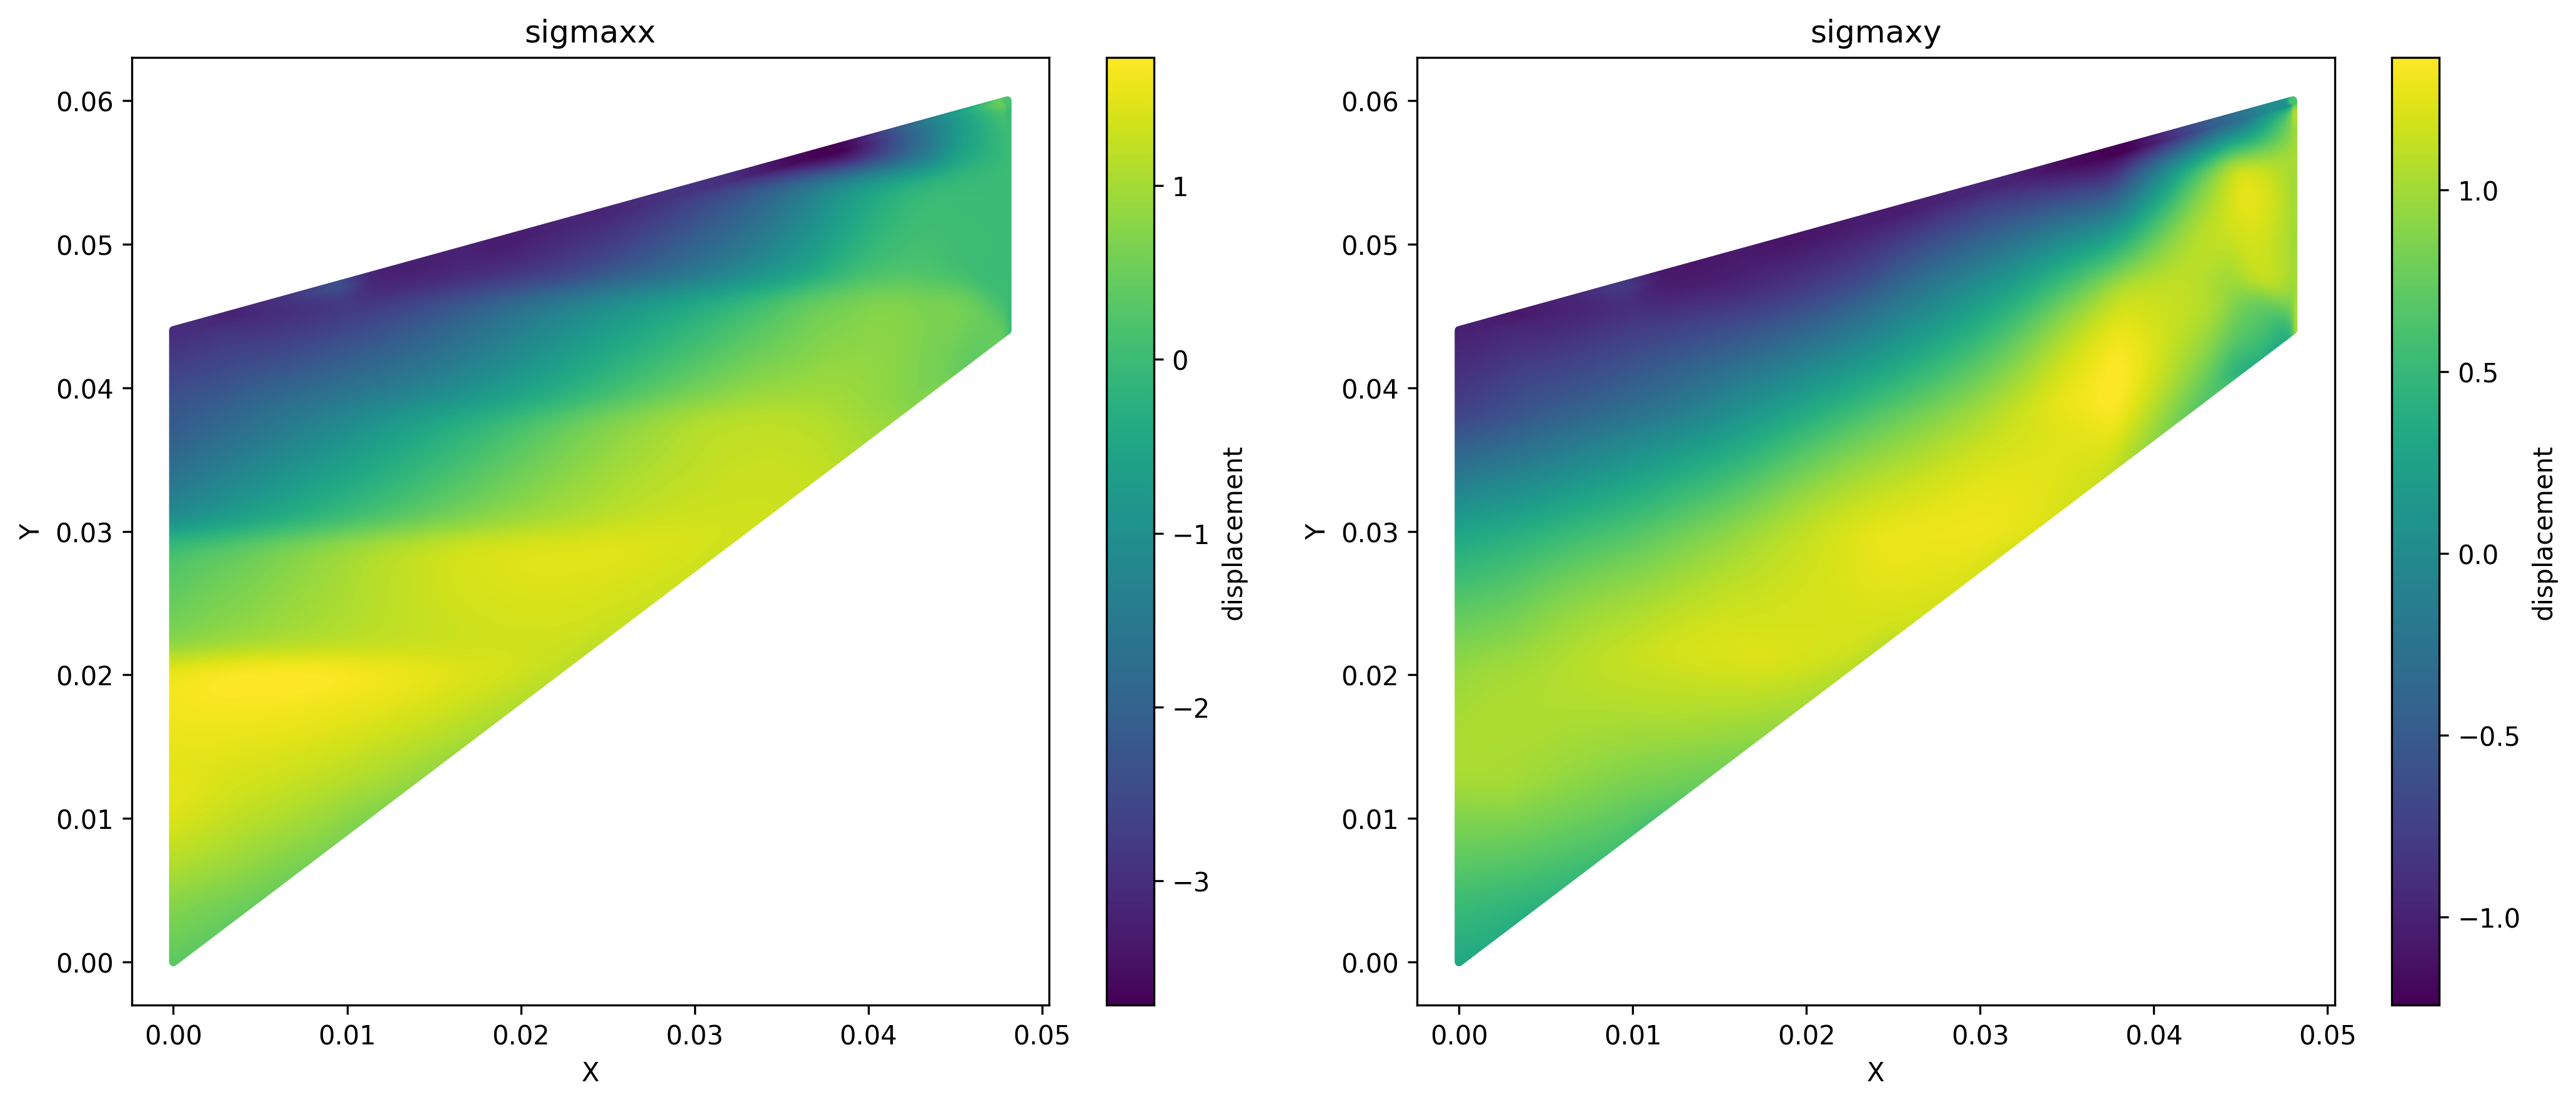

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), dpi=300)
plot_deformation(sigmaxx_test, x_batch_test,ax1,"sigmaxx")
plot_deformation(sigmaxy_test, x_batch_test,ax2,"sigmaxy")
plt.tight_layout()
plt.show()

### FBPINNs Vs FEM Comparison

[INFO] 2024-03-26 23:59:47 - x_batch
[INFO] 2024-03-26 23:59:47 - (10201, 2), float64, ndarray
[INFO] 2024-03-26 23:59:47 - x_take
[INFO] 2024-03-26 23:59:47 - (36882, 2), float64, ndarray


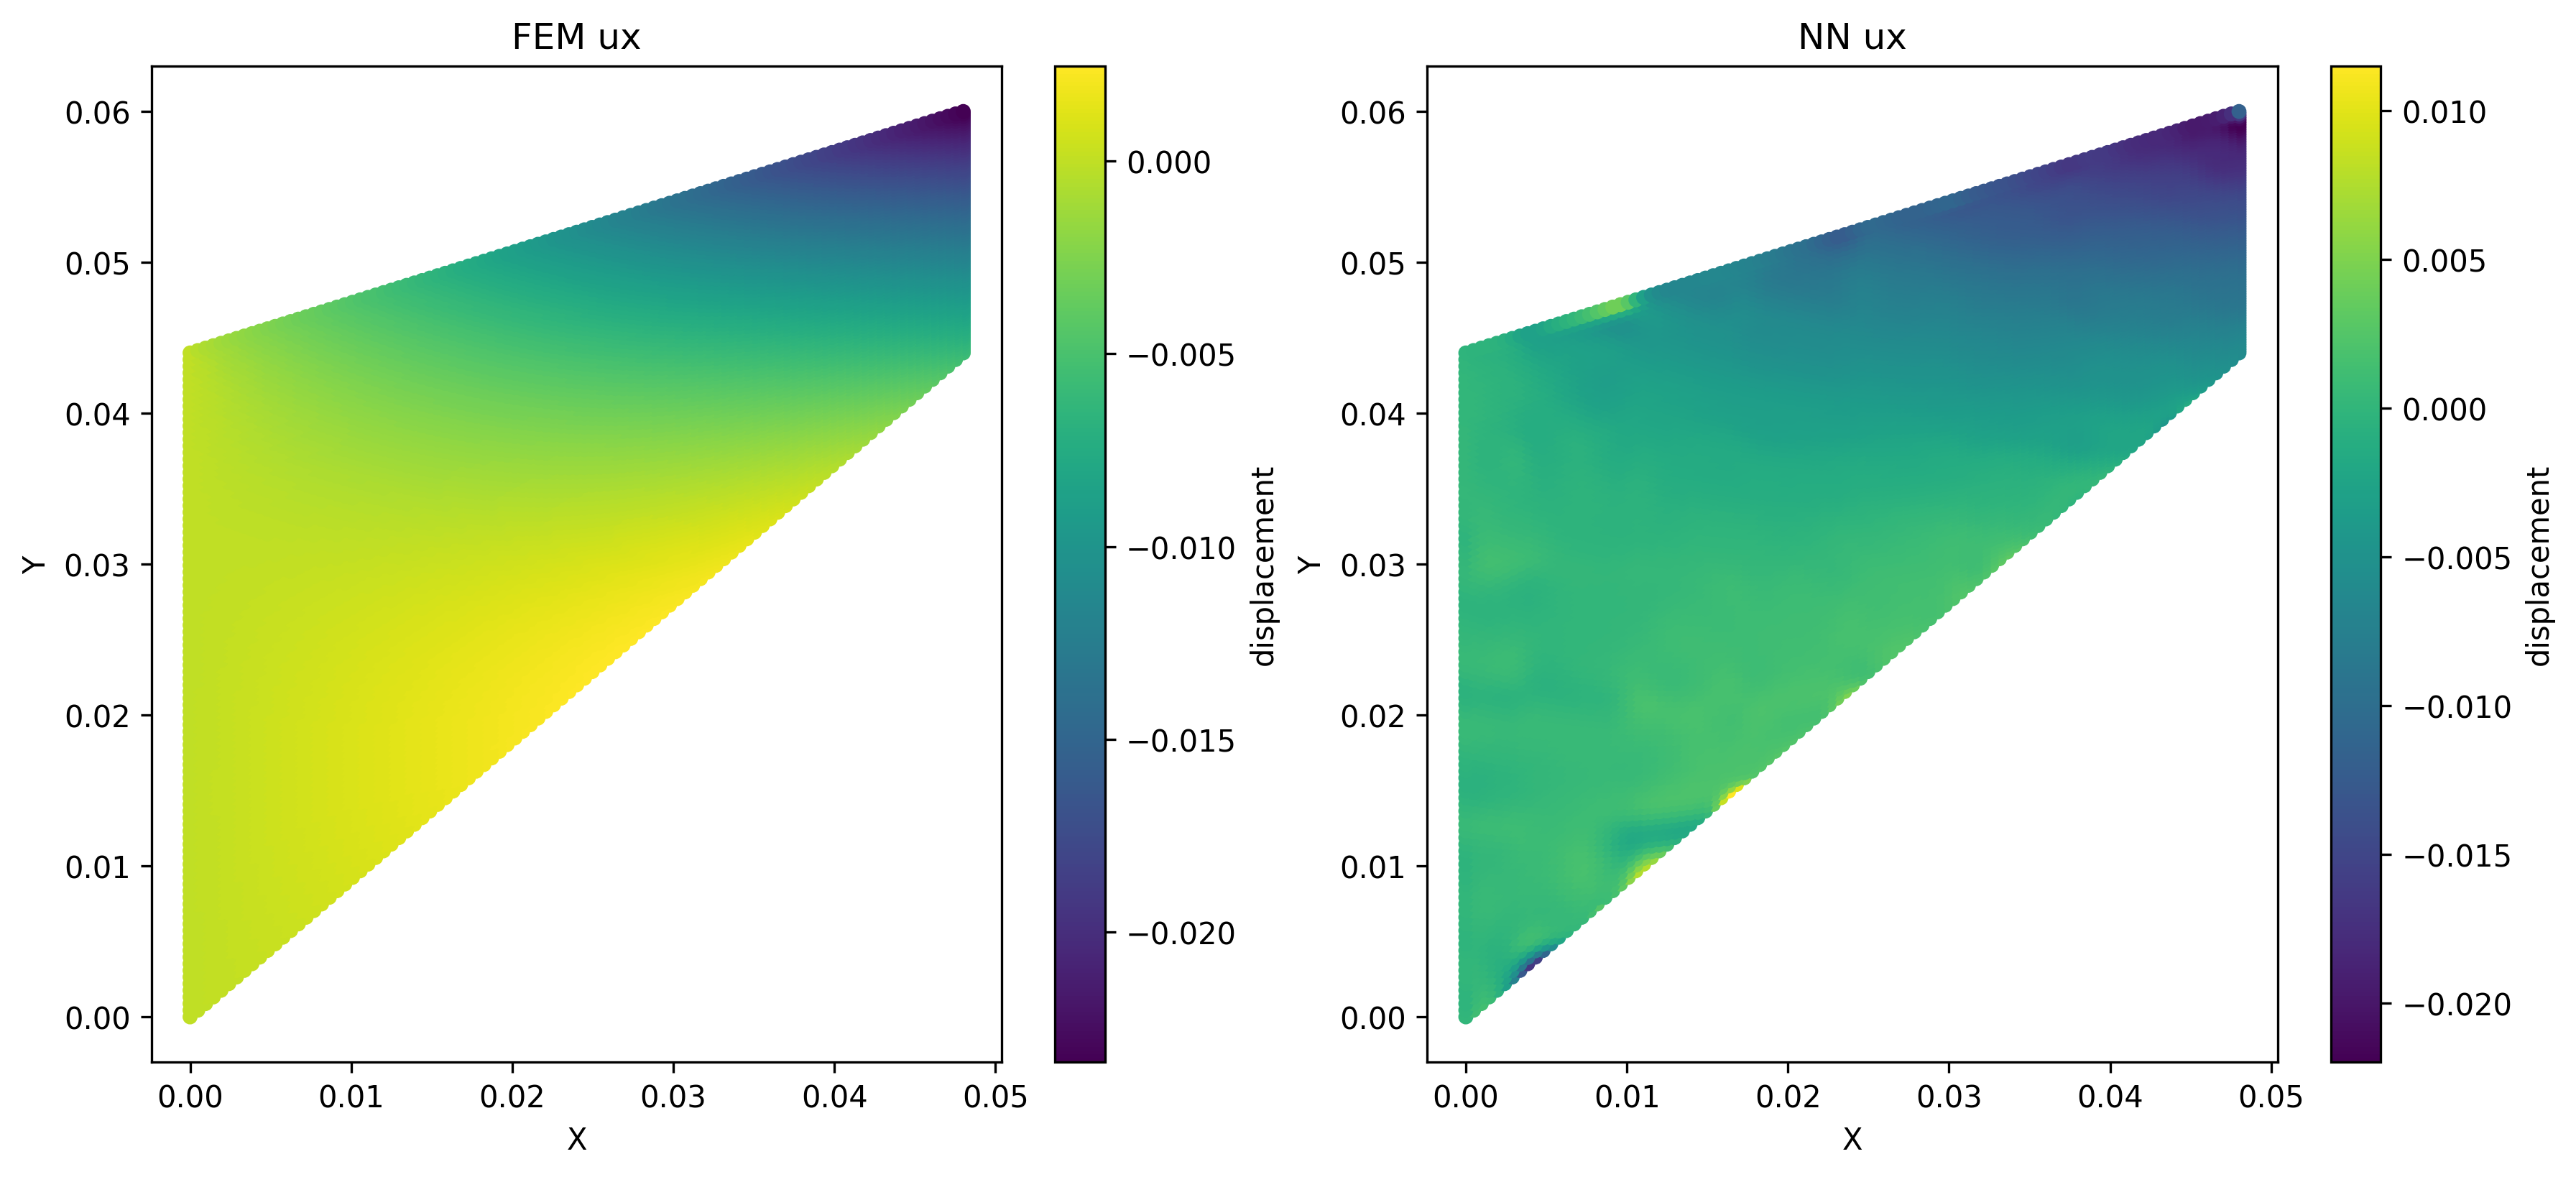

In [40]:
import pandas as pd 

FEM = pd.read_csv("FEM_result/stats.csv")

FEM = FEM[['u:0', 'u:1', 'Points:0', 'Points:1']].rename(columns={'u:0': 'ux', 'u:1': 'uy', 'Points:0': 'x', 'Points:1': 'y'})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), dpi=300)
plot_deformation( FEM["ux"],FEM[['x', 'y']].values, ax1, "FEM ux", 16)

# NN sol
x_batch_test = FEM[['x', 'y']].values
out = FBPINN_solution(c, all_params, active, x_batch_test)

ux_test, uy_test, sigaxx_test, sigmayy_test, sigmaxy_test  = out[:,0:1],out[:,1:2],out[:,2:3],out[:,3:4],out[:,4:5]
plot_deformation(ux_test, x_batch_test, ax2, set_title="NN ux", point_size=16)


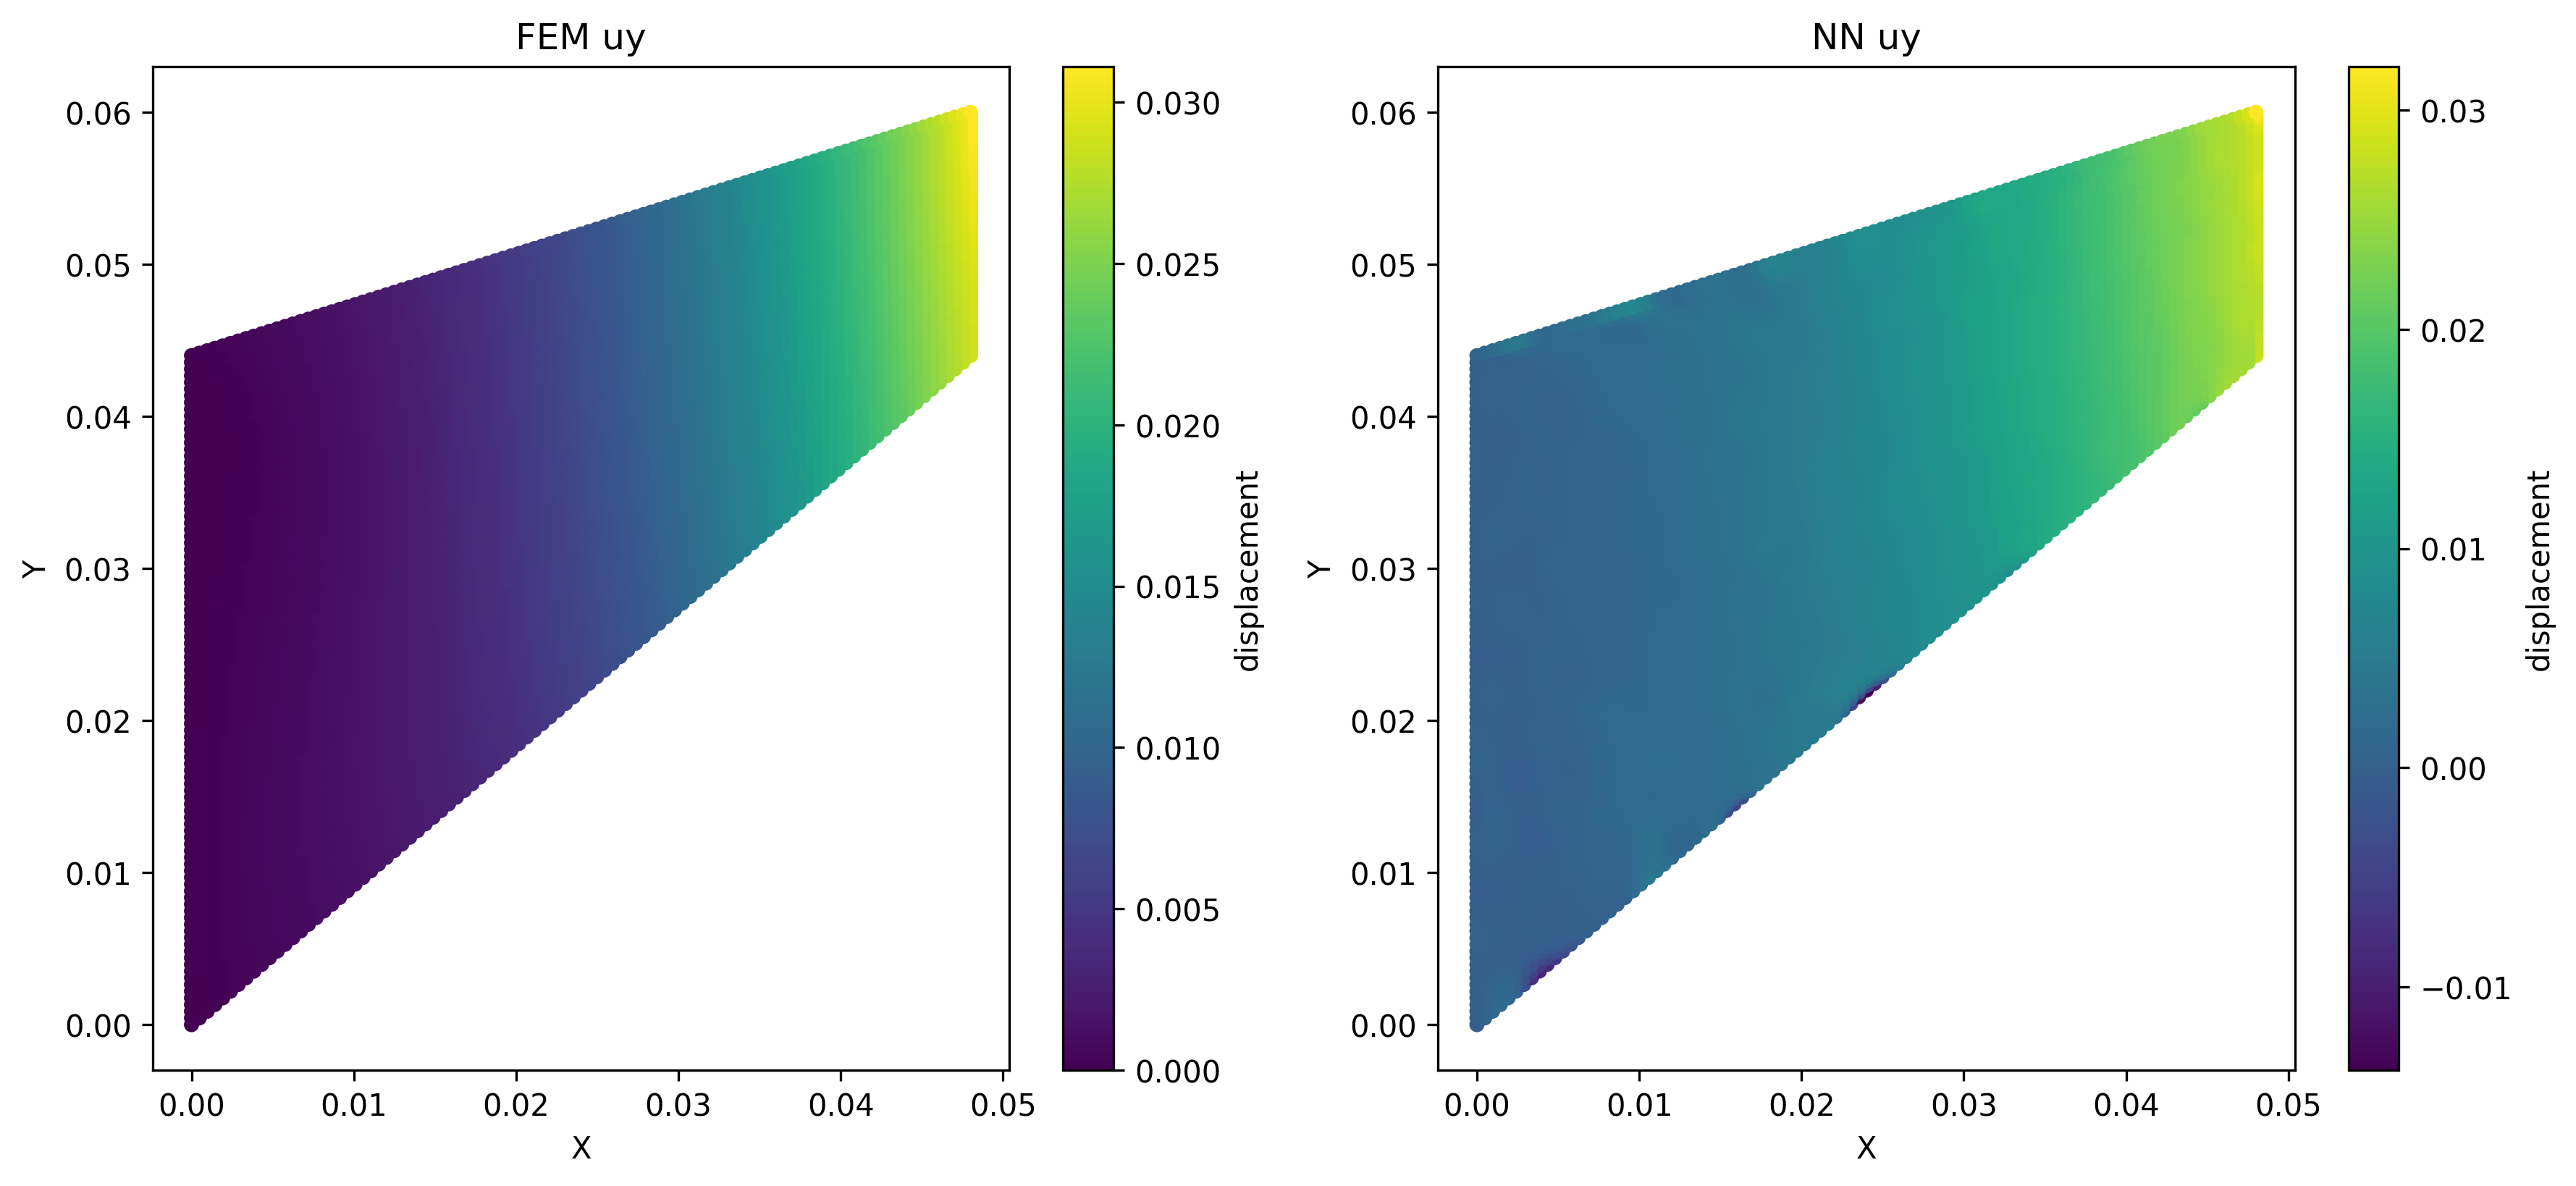

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), dpi=300)
plot_deformation( FEM["uy"],FEM[['x', 'y']].values, ax1, "FEM uy", 16)
plot_deformation(uy_test, x_batch_test, ax2, set_title="NN uy", point_size=16)

Show the difference 

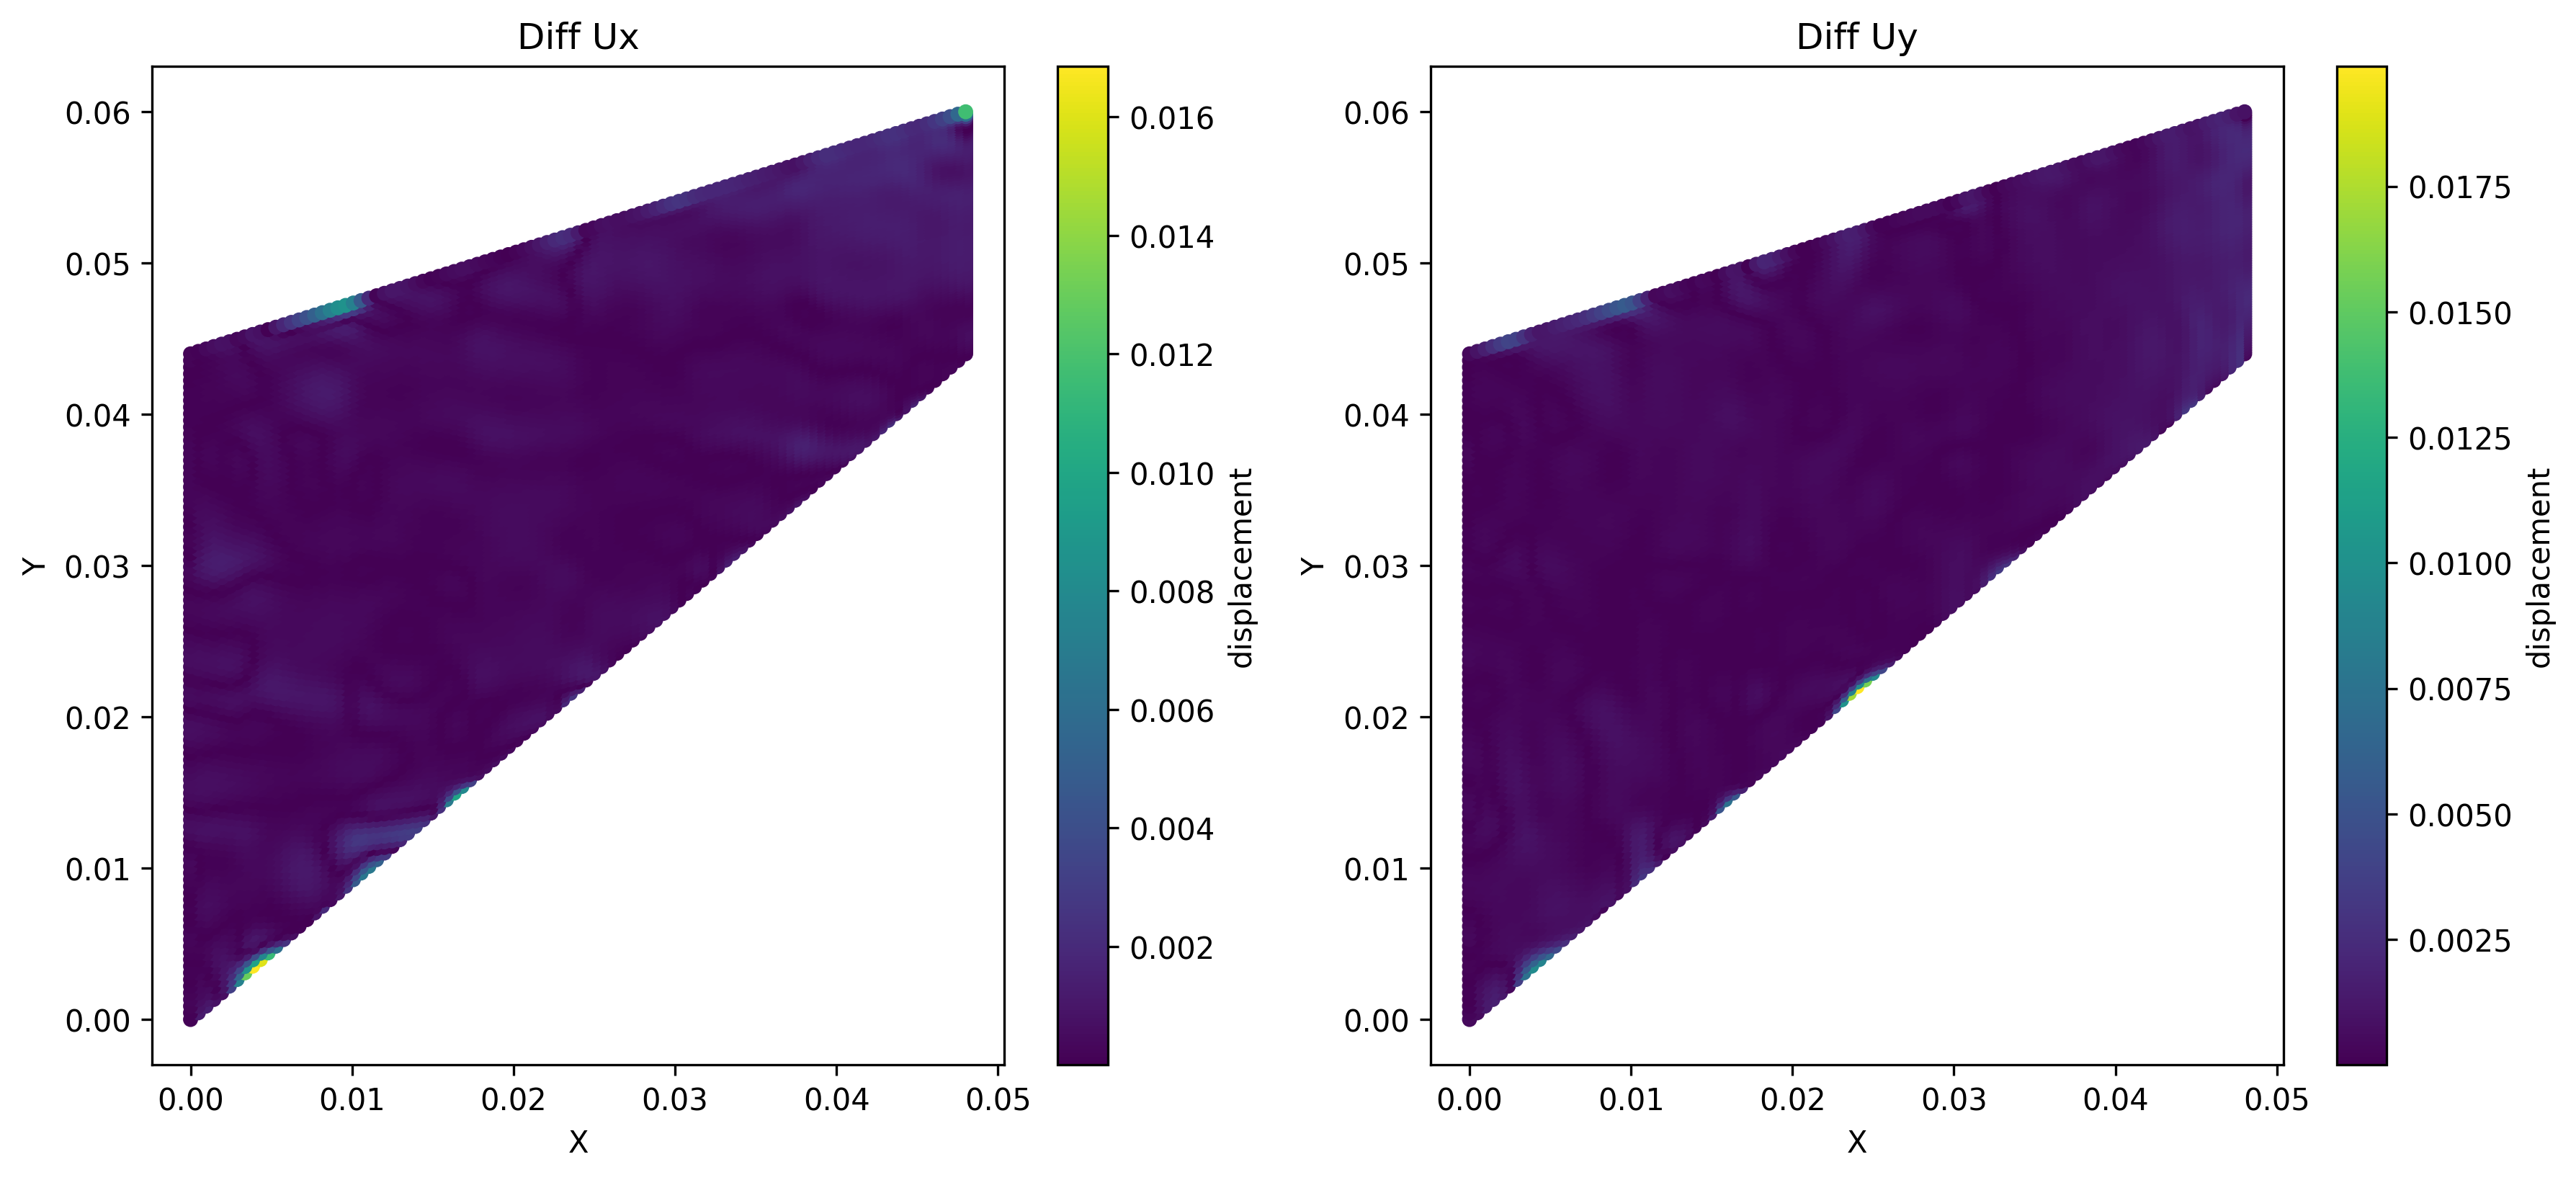

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), dpi=300)
plot_deformation(abs(FEM["ux"] - ux_test.reshape(-1)), x_batch_test, ax1, set_title="Diff Ux", point_size=16)
plot_deformation(abs(FEM["uy"] - uy_test.reshape(-1)), x_batch_test, ax2, set_title="Diff Uy", point_size=16)
plt.show()

### PINNTrainer vs FEM

In [15]:
run = f"PINN_{tag}_{problem.__name__}_{network.__name__}_{nc}-nCol_{epochs}-epochs_{h}-layers_{p}-hidden_{wo}_wo_fixedWeights_{subdomain_xs}"
run

'PINN_adaptive_CooksProblemForwardSoftVersion2_FCN_(20, 20)-nCol_20000-epochs_1-layers_128-hidden_1.6_wo_fixedWeights_[[0.014, 0.034], [0.018, 0.042]]'

In [20]:
c = Constants(
    run=run,
    domain=domain,
    domain_init_kwargs=domain_init_kwargs,
    problem=problem,
    problem_init_kwargs=problem_init_kwargs,
    decomposition=decomposition,
    decomposition_init_kwargs=decomposition_init_kwargs,
    network=network,
    network_init_kwargs=network_init_kwargs,
    scheduler=scheduler,
    scheduler_kwargs=scheduler_kwargs,
    ns=(nc,),# use 200 collocation points for training
    n_test=(50,50),# use 500 points for testing
    n_steps=epochs,# number of training steps
    clear_output=True,
    show_figures=False,
    test_freq=150000,
    model_save_freq=5000,
    skip_plot_at_first=True,
    sampler='sobol',
)

from fbpinns.trainers import PINNTrainer

c["network_init_kwargs"] = dict(layer_sizes=[2,128,128,128,5]) # use a larger neural network

PINNrun = PINNTrainer(c)
PINNrun.train()

[INFO] 2024-03-26 22:25:18 - <fbpinns.constants.Constants object at 0x000001654C9C1CA0>
run: PINN_adaptive_CooksProblemForwardSoftVersion2_FCN_(20, 20)-nCol_20000-epochs_1-layers_128-hidden_1.6_wo_fixedWeights_[[0.014, 0.034], [0.018, 0.042]]
domain: <class 'cooksDomain.CooksDomainND'>
domain_init_kwargs: {'corners': Array([[0.   , 0.   ],
       [0.   , 0.044],
       [0.048, 0.06 ],
       [0.048, 0.044]], dtype=float32)}
problem: <class 'CooksMembrane.cooksProblem.CooksProblemForwardSoftVersion2'>
problem_init_kwargs: {'lambda_true': 4, 'mu_true': 5, 'nbc_points_right': 300, 'nbc_points_top': 200, 'nbc_points_bottom': 200, 'dbc_points_left': 300, 'sd': 0.1}
decomposition: <class 'fbpinns.decompositions.RectangularDecompositionND'>
decomposition_init_kwargs: {'subdomain_xs': [[0.014, 0.034], [0.018, 0.042]], 'subdomain_ws': [array([0.032, 0.032]), array([0.0384, 0.0384])], 'unnorm': (0.0, 3.0)}
network: <class 'fbpinns.networks.FCN'>
network_init_kwargs: {'layer_sizes': [2, 128, 128,

c:\Users\tirth\anaconda3\envs\fbpinns\Lib\site-packages\scipy\stats\_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


[INFO] 2024-03-26 22:25:19 - x_batch
[INFO] 2024-03-26 22:25:19 - (400, 2), float32, JVPTracer
[INFO] 2024-03-26 22:25:19 - x_batch
[INFO] 2024-03-26 22:25:19 - (300, 2), float32, DynamicJaxprTracer
[INFO] 2024-03-26 22:25:19 - x_batch
[INFO] 2024-03-26 22:25:19 - (200, 2), float32, DynamicJaxprTracer
[INFO] 2024-03-26 22:25:19 - x_batch
[INFO] 2024-03-26 22:25:19 - (300, 2), float32, DynamicJaxprTracer
[INFO] 2024-03-26 22:25:19 - x_batch
[INFO] 2024-03-26 22:25:19 - (200, 2), float32, DynamicJaxprTracer
[INFO] 2024-03-26 22:25:22 - [i: 0/20000] Compiling done (2.44 s)
[INFO] 2024-03-26 22:25:35 - [i: 1000/20000] loss: 296657.1250 rate: 77.0 elapsed: 0.00 hr PINN_adaptive_CooksProblemForwardSoftVersion2_FCN_(20, 20)-nCol_20000-epochs_1-layers_128-hidden_1.6_wo_fixedWeights_[[0.014, 0.034], [0.018, 0.042]]
[INFO] 2024-03-26 22:25:50 - [i: 2000/20000] loss: 103075.3203 rate: 64.6 elapsed: 0.01 hr PINN_adaptive_CooksProblemForwardSoftVersion2_FCN_(20, 20)-nCol_20000-epochs_1-layers_128-h

{'static': {'domain': {'xd': 2,
   'corners': Array([[0.   , 0.   ],
          [0.   , 0.044],
          [0.048, 0.06 ],
          [0.048, 0.044]], dtype=float32)},
  'problem': {'dims': (5, 2),
   'E': 12.222222222222221,
   'nu': 0.2222222222222222,
   'nbc_points_right': 300,
   'nbc_points_top': 200,
   'nbc_points_bottom': 200,
   'dbc_points_left': 300,
   'sd': 0.1,
   'weight_mm_1': 1.0,
   'weight_mm_2': 1.0,
   'weight_mm_3': 1.0,
   'weight_bl_1': 1.0,
   'weight_bl_2': 1.0,
   'weight_nbc_top': 2000000.0,
   'weight_nbc_bottom': 1000000.0,
   'weight_nbc_right': 1000000.0,
   'weight_dbc_left': 1000000.0}},
 'trainable': {'network': {'subdomain': {'layers': [(Array([[ 0.45740262,  1.2425187 ],
             [-0.7083221 , -1.3988295 ],
             [ 0.52046996,  0.5164834 ],
             [-0.47791705,  0.17407516],
             [ 1.0839195 ,  0.3959803 ],
             [-0.41815627, -1.366262  ],
             [-0.5611542 ,  0.76069635],
             [ 0.9191555 ,  0.39285344]

In [21]:
from FBPINNsModel.plot import load_FBPINN, load_PINN, exact_solution
from fbpinns.analysis import load_model

c, model = load_model(run, rootdir="results/")

# Test model
from fbpinns.analysis import FBPINN_solution, PINN_solution
i, all_params, all_opt_states, u_test_losses = model
x_batch_test = domain.sample_interior(all_params=all_params, key=None, sampler="grid", batch_shape=(500,500))
out = PINN_solution(c, all_params, x_batch_test)

ux_test, uy_test, sigaxx_test, sigmayy_test, sigmaxy_test  = out[:,0:1],out[:,1:2],out[:,2:3],out[:,3:4],out[:,4:5]

[INFO] 2024-03-26 22:31:15 - Loading model from:
results/models/PINN_adaptive_CooksProblemForwardSoftVersion2_FCN_(20, 20)-nCol_20000-epochs_1-layers_128-hidden_1.6_wo_fixedWeights_[[0.014, 0.034], [0.018, 0.042]]/model_00020000.jax


[INFO] 2024-03-26 22:31:16 - x_batch
[INFO] 2024-03-26 22:31:16 - (250000, 2), float32, ArrayImpl


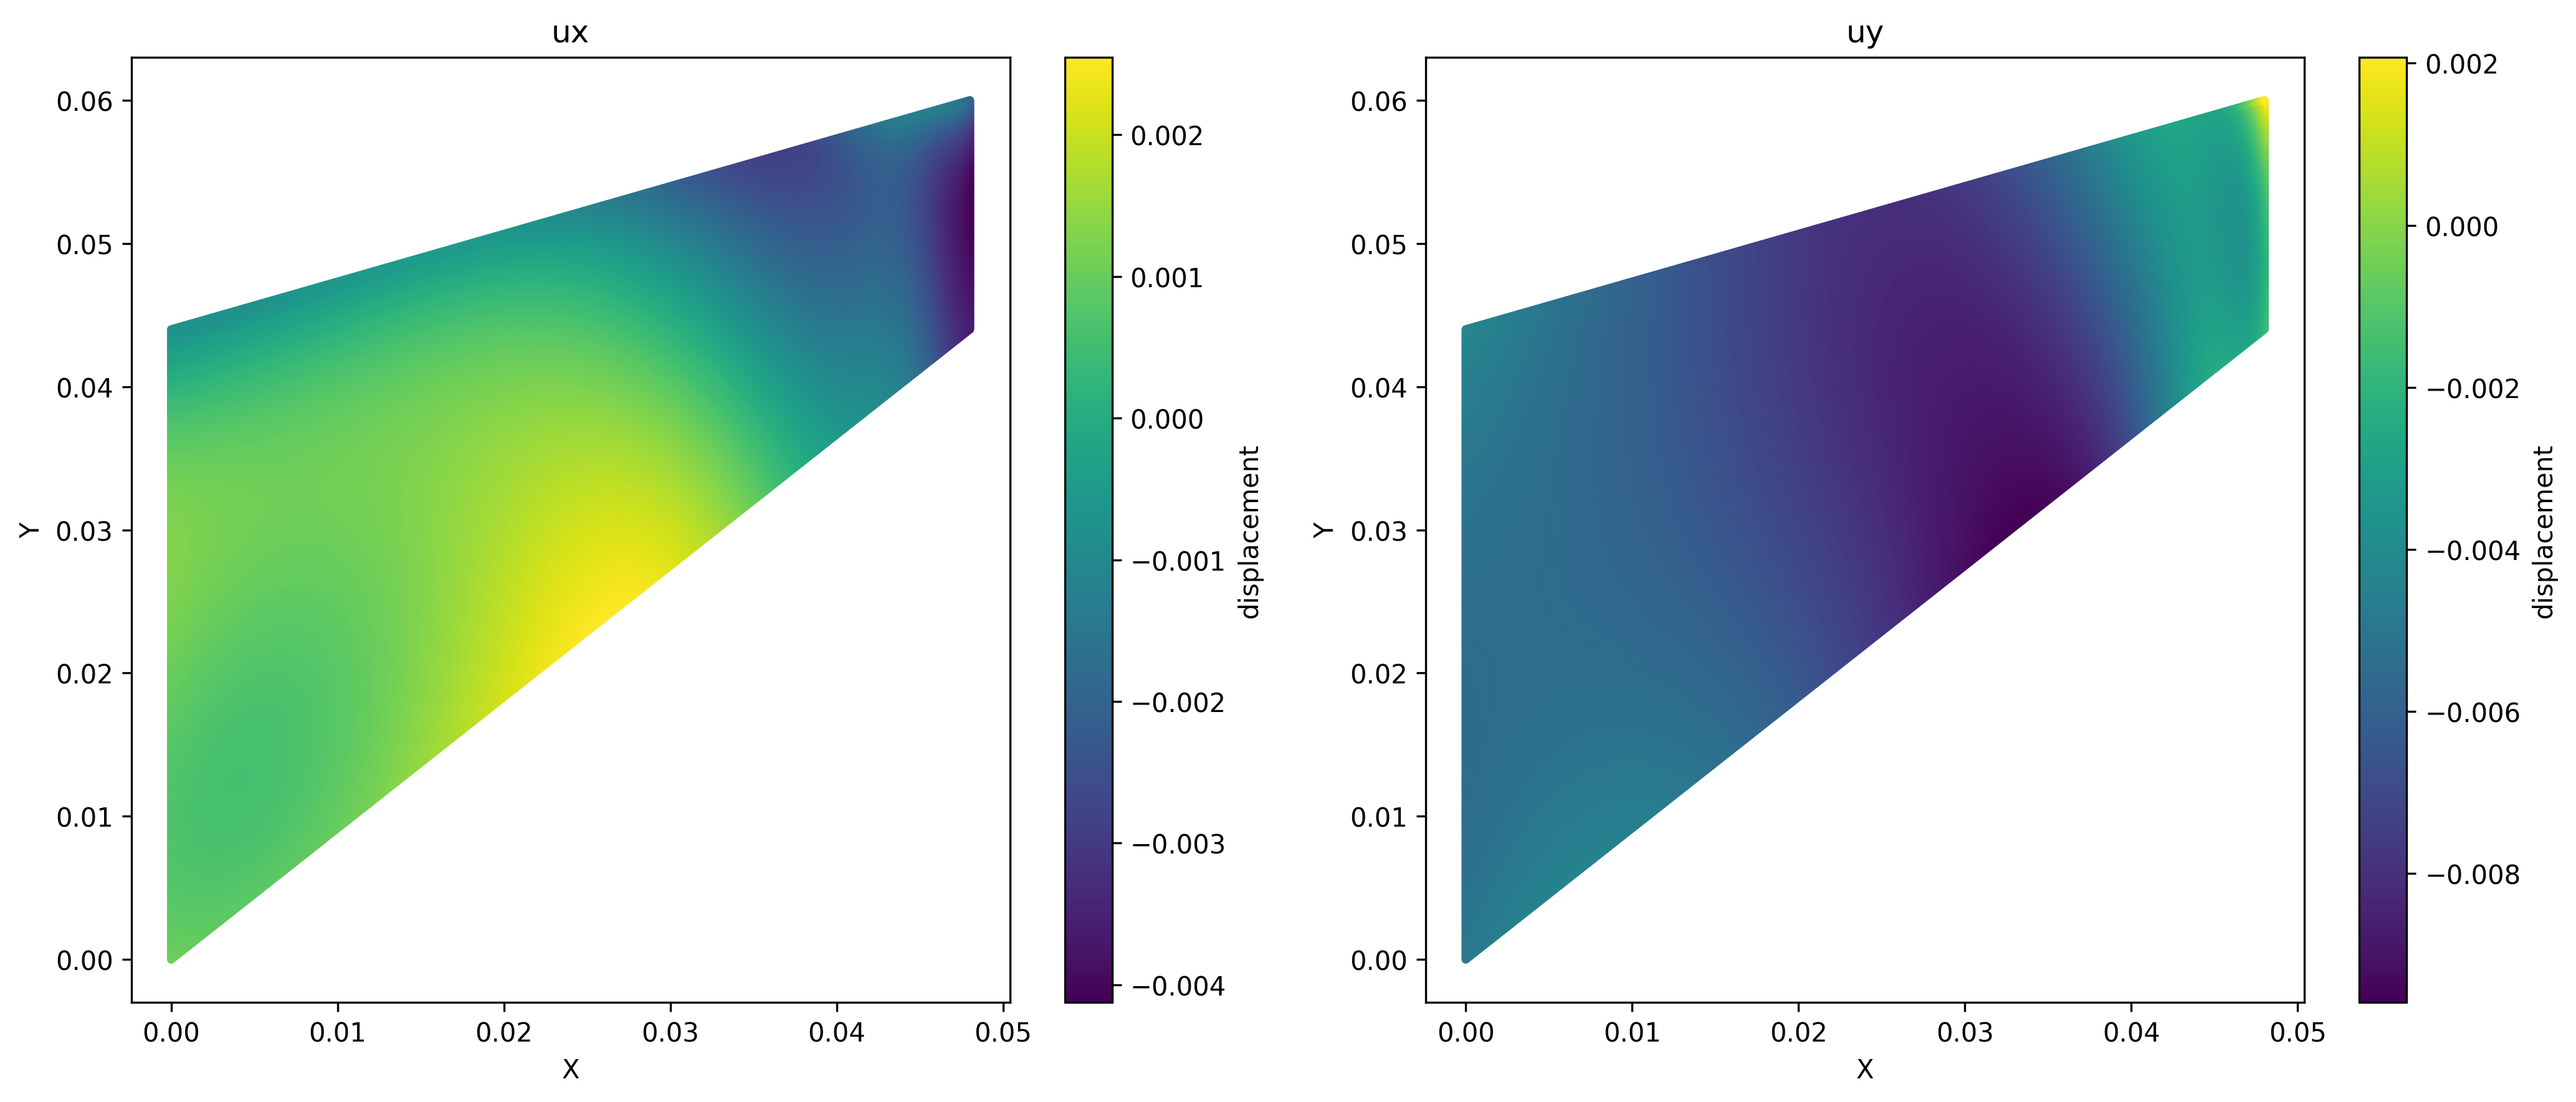

In [22]:
from CooksMembrane.util import plot_deformation

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), dpi=300)
plot_deformation(ux_test, x_batch_test,ax1,"ux")
plot_deformation(uy_test, x_batch_test,ax2,"uy")
plt.tight_layout()
plt.show()

[INFO] 2024-03-26 22:31:40 - Loading model from:
results/models/PINN_adaptive_CooksProblemForwardSoftVersion2_FCN_(20, 20)-nCol_20000-epochs_1-layers_128-hidden_1.6_wo_fixedWeights_[[0.014, 0.034], [0.018, 0.042]]/model_00020000.jax
[INFO] 2024-03-26 22:31:40 - x_batch
[INFO] 2024-03-26 22:31:40 - (10201, 2), float64, ndarray


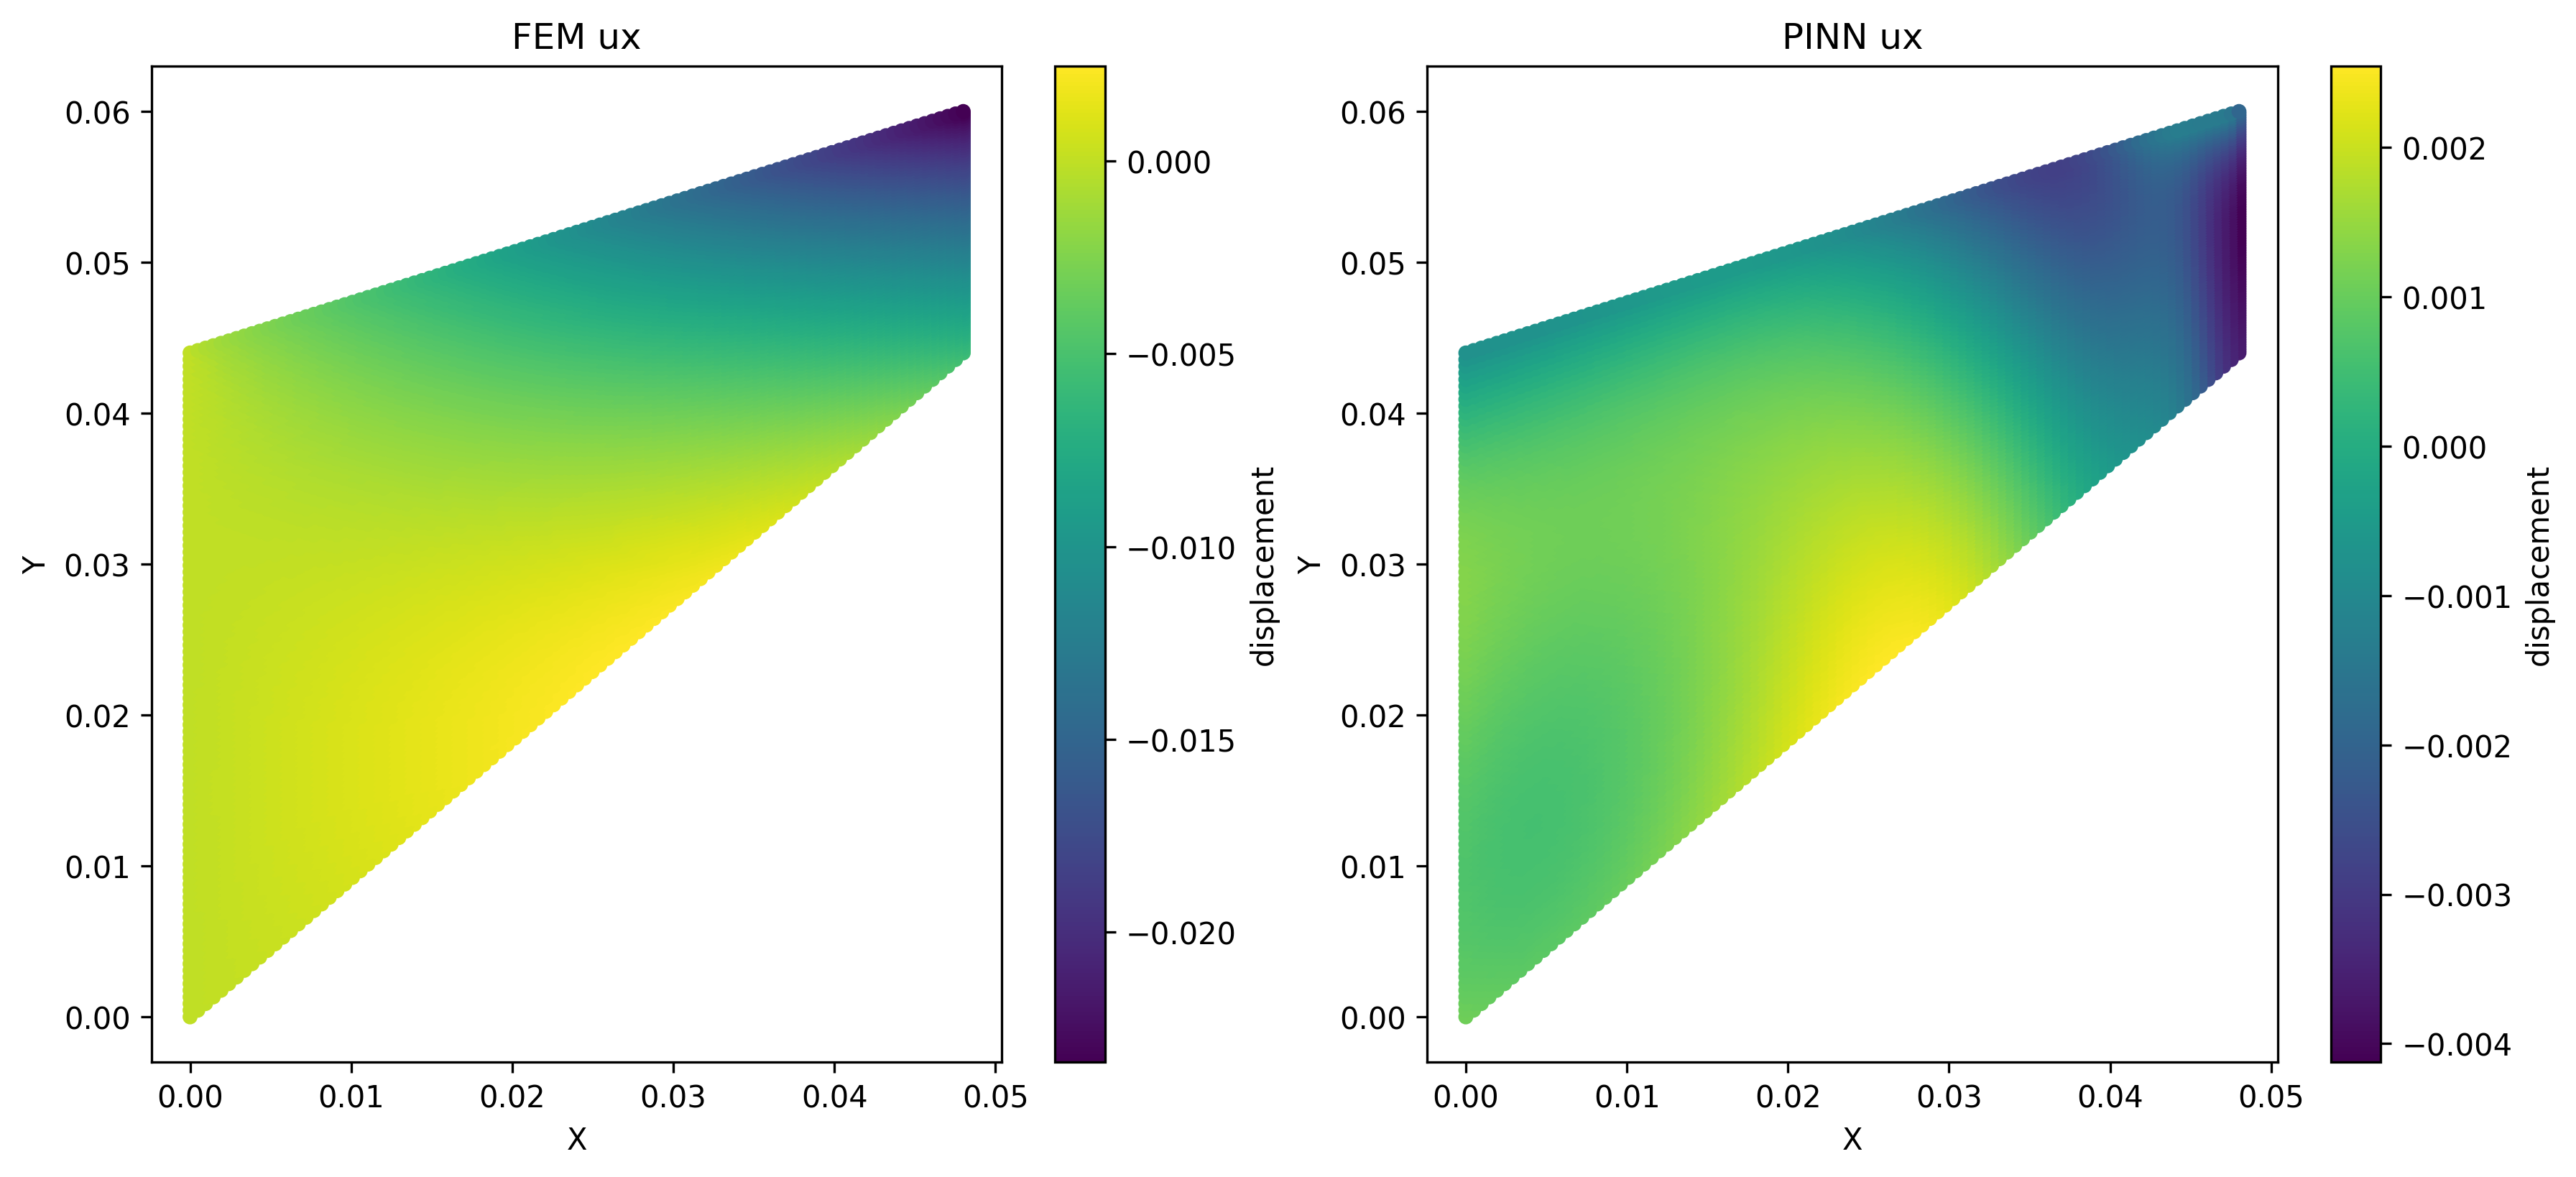

In [23]:
from fbpinns.analysis import FBPINN_solution, PINN_solution
from fbpinns.analysis import load_model

c, model = load_model(run, rootdir="results/")
all_params, domain = model[1], c.domain

x_batch_test = FEM[['x', 'y']].values
out_pinn = PINN_solution(c, all_params, x_batch_test)

ux_pinn, uy_pinn, sigaxx_pinn, sigmayy_pinn, sigmaxy_pinn  = out_pinn[:,0:1],out_pinn[:,1:2],out_pinn[:,2:3],out_pinn[:,3:4],out_pinn[:,4:5]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), dpi=300)
plot_deformation( FEM["ux"],FEM[['x', 'y']].values, ax1, "FEM ux", 16)
plot_deformation(ux_pinn, x_batch_test, ax2, set_title="PINN ux", point_size=16)


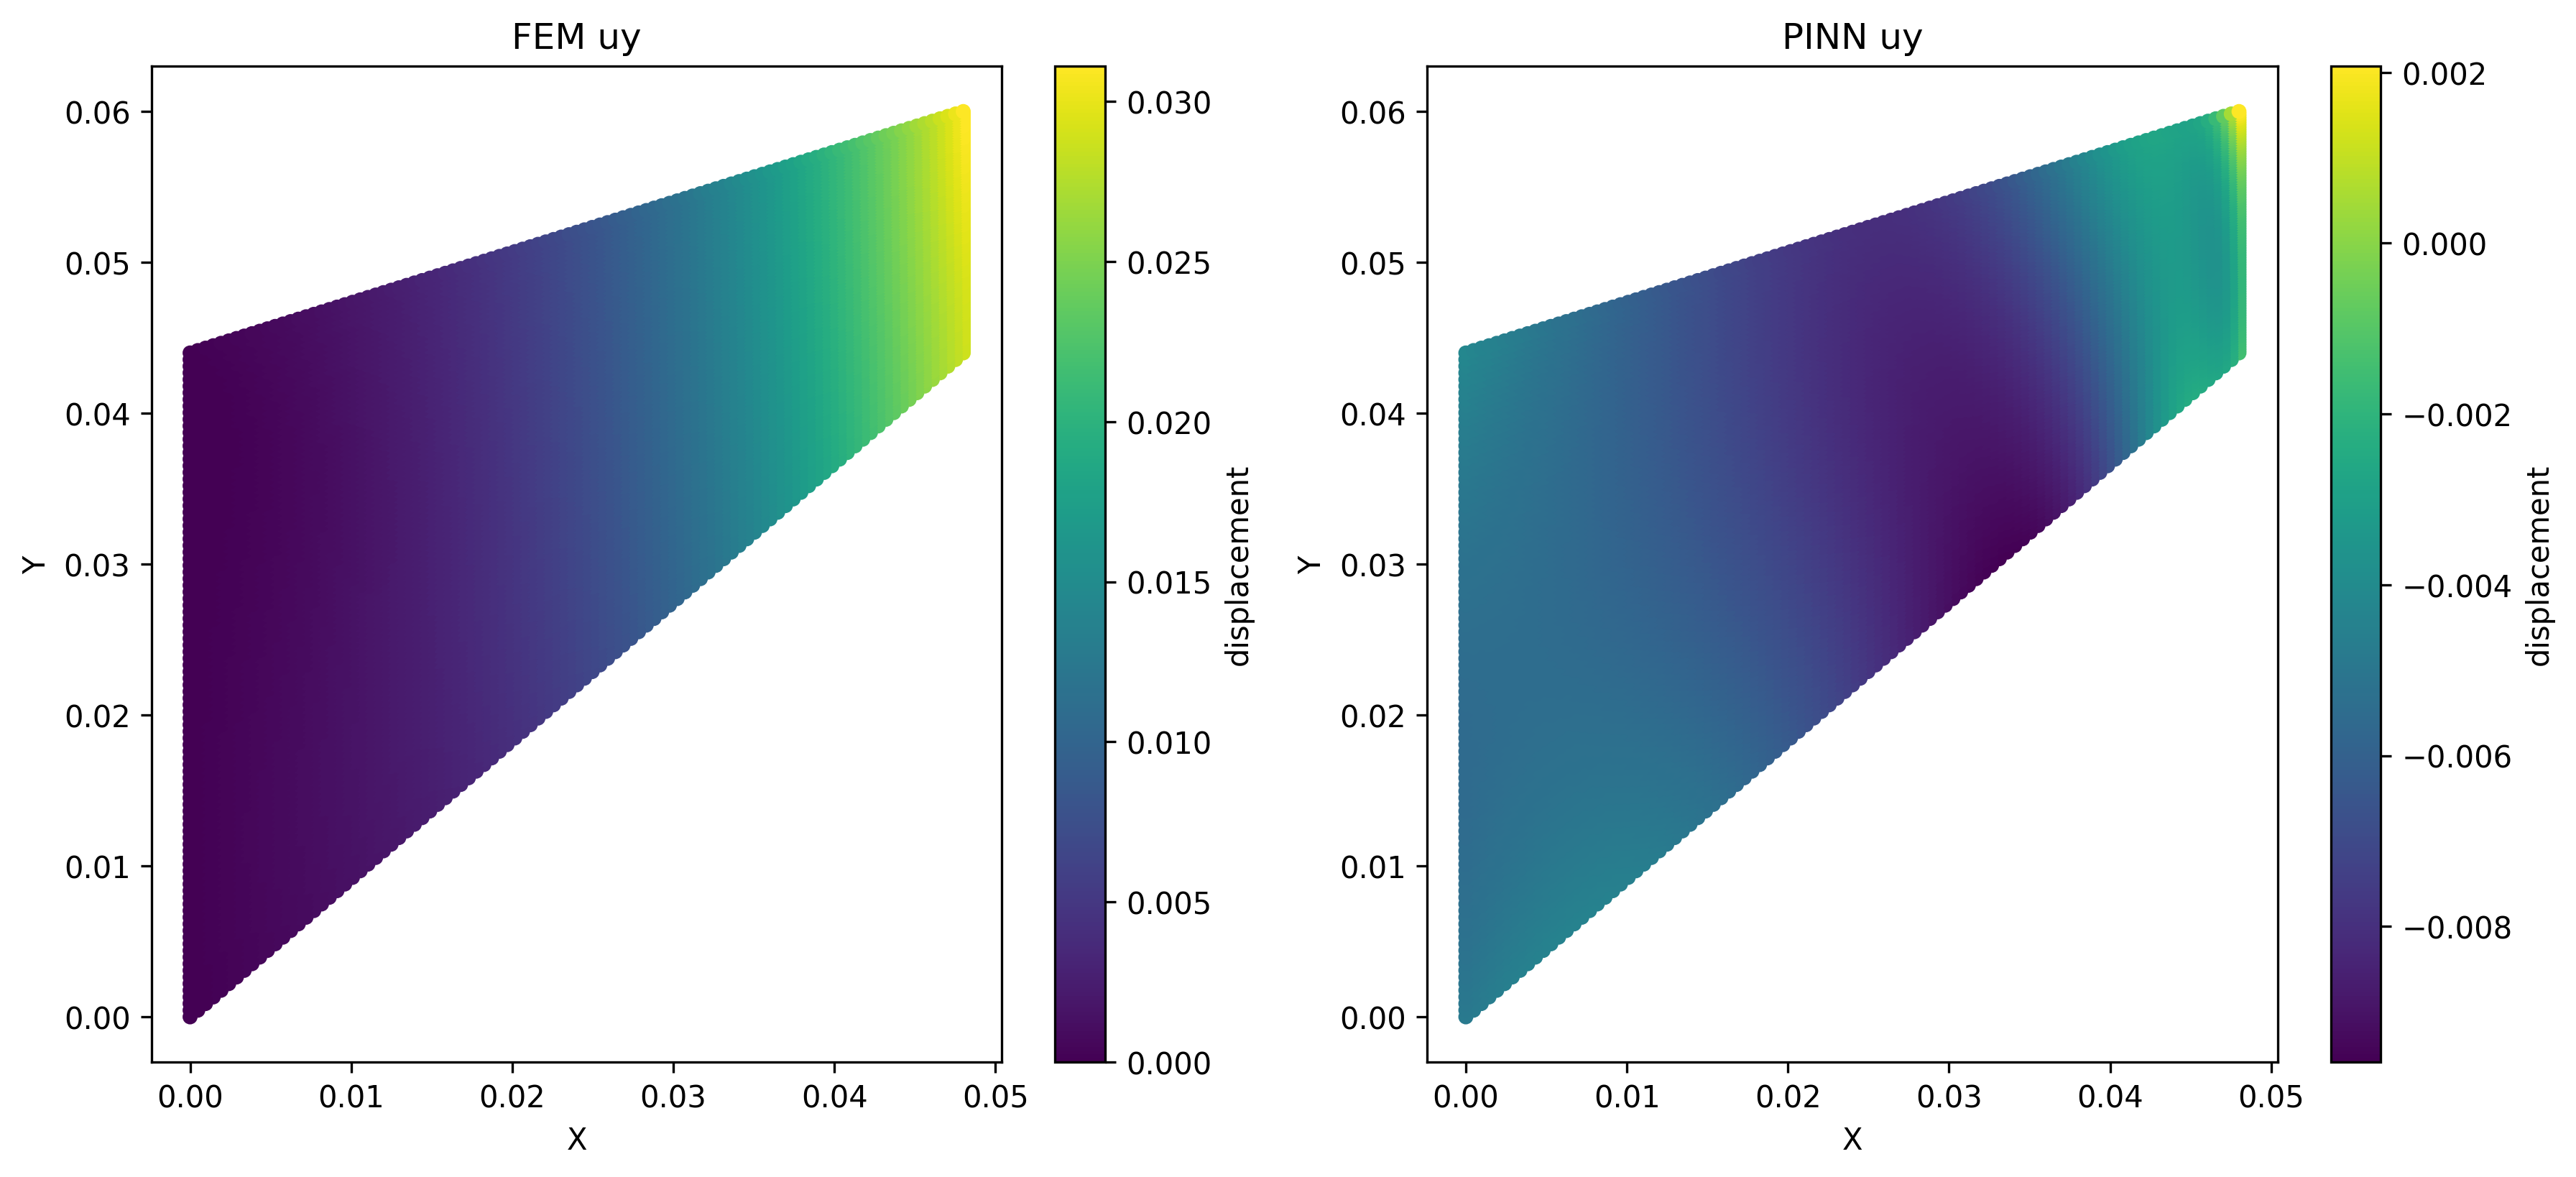

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), dpi=300)
plot_deformation( FEM["uy"],FEM[['x', 'y']].values, ax1, "FEM uy", 16)
plot_deformation(uy_pinn, x_batch_test, ax2, set_title="PINN uy", point_size=16)

In [13]:
import jax.numpy as jnp

exp = jnp.exp
exp(-0.04 / 0.3)

Array(0.87517333, dtype=float32, weak_type=True)

In [48]:
tanh = jnp.tanh
tanh(-0.002/(.01))

Array(-0.19737528, dtype=float32, weak_type=True)